In [16]:
import json
import pickle
import random

class CandidateDataset(object):
    def __init__(self, input_file, tokenizer, max_desc_len=50, preprocessed=False):
        self.tokenizer = tokenizer
        self.max_title_len = 0
        self.max_desc_len = 0
        self.data = self._read(input_file, preprocessed)
        
    def save_preprocessed_data(self, fn):
        with open(fn, 'wb') as f:
            pickle.dump(self.data, f)
        
    def _preprocess(self, title, description):
        title = self.tokenizer.tokenize(title)
        description = self.tokenizer.tokenize(description)
        
        if len(title) > self.max_title_len:
            self.max_title_len = len(title)
        if len(description) > self.max_desc_len:
            self.max_desc_len = len(description)
        
        title = self.tokenizer.convert_tokens_to_ids(title)
        description = self.tokenizer.convert_tokens_to_ids(description)
        return title, description
        
    def _read(self, fn, preprocessed=False):
        data = {}
        if preprocessed:
            with open(fn, 'rb') as f:
                data = pickle.load(f)
            return data
        
        with open(fn, 'r') as f:
            for line in f:
                line = line.rstrip()
                if not line:
                    continue
                    
                line = json.loads(line)
                title, desc = self._preprocess(line['title'], line['description'])
                data[int(line['id'])] = {
                    "title": line['title'], 
                    "description": line['description'], 
                    'title_ids': title, 
                    'description_ids': desc
                }
                
        return data
    
    def get_page(self, page_ids, max_title_len=50, max_desc_len=100):
        input_seq =  [self.data[page_id]['input_seq'] for page_id in page_ids]
        input_seq = [['[CLS]'] + d['title_ids'][:max_title_len] + ['[SEP]'] + d['description_ids'][:max_desc_len] + ['[SEP]'] for d in input_seq]
        input_seq = [self.tokenizer.convert_tokens_to_ids(d) for d in input_seq]
        
        return input_seq
        

class MentionDataset(object):
    def __init__(self, input_file, tokenizer):
        self.input_file = input_file
        self.tokenizer = tokenizer
    
    def _preprocess(self, line, max_ctxt_len=32):
        left_ctxt = self.tokenizer.tokenize(line['left_context'])
        mention_tokens = self.tokenizer.tokenize(line['mention'])
        right_ctxt = self.tokenizer.tokenize(line['right_context'])
        
        input_seq = ['[CLS]'] + left_ctxt[-max_ctxt_len:] + ['[M]'] + mention_tokens + ['[/M]'] + right_ctxt[:max_ctxt_len] + ['[SEP]']
        input_seq = self.tokenizer.convert_tokens_to_ids(input_seq)
        input_label = line['linkpage_id']
        return input_seq, input_label
    
    def batch(self, batch_size=16, random_bsz=100000, max_ctxt_len=32):
        batch_input, batch_labels = [], []
        with open(self.input_file, 'r') as f:
            for line in f:
                if len(batch_input) >= random_bsz:
                    random_idx = [i for i in range(len(batch_input))]
                    random.shuffle(random_idx)
                    
                    for batch_idx in range(0, len(batch_input), batch_size):
                        end_batch_idx = min(batch_idx+batch_size, len(batch_input)+1)
                        inbatch_input = [batch_input[random_idx[i]] for i in range(batch_idx, end_batch_idx)]
                        inbatch_labels = [batch_labels[random_idx[i]] for i in range(batch_idx, end_batch_idx)]
                    
                        yield inbatch_input, inbatch_labels
                    batch_input, batch_labels = [], []
                    
                line = line.rstrip()
                if not line:
                    continue
                line = json.loads(line)
                
                ids, labels = self._preprocess(line)
                batch_input.append(ids)
                batch_labels.append(labels)

                
            if len(batch_input) > 0:
                random_idx = [i for i in range(len(batch_input))]
                random.shuffle(random_idx)
                    
                for batch_idx in range(0, len(batch_input), batch_size):
                    end_batch_idx = min(batch_idx+batch_size, len(batch_input)+1)
                    inbatch_input = [batch_input[random_idx[i]] for i in range(batch_idx, end_batch_idx)]
                    inbatch_labels = [batch_labels[random_idx[i]] for i in range(batch_idx, end_batch_idx)]
                    
                    yield inbatch_input, inbatch_labels

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')
tokenizer.add_special_tokens({"additional_special_tokens": ["[M]", "[/M]"]})

dataset = MentionDataset('/data1/ujiie/wiki_resource/training_data.jsonl', tokenizer)

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')

dataset = CandidateDataset('/data1/ujiie/wiki_resource/id_title_description.jsonl', tokenizer)
#dataset = CandidateDataset('/data1/ujiie/wiki_resource/pages_preprocessed_for_bert-base-japanese.pkl', tokenizer, preprocessed=True)
dataset.save_preprocessed_data('/data1/ujiie/wiki_resource/pages_preprocessed_for_bert-base-japanese.pkl')
#print(len(dataset.data[0])) 

In [4]:
titles = [d['title_ids'] for d in dataset.data.values()]
desc = [d['description_ids'] for d in dataset.data.values()]

In [13]:
t = [''.join(tokenizer.convert_ids_to_tokens(d)) for d in desc if len(d) > 200]
len(t), len(titles)

(5383, 1136321)

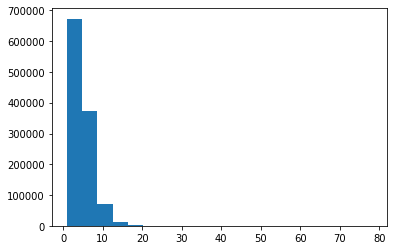

In [16]:
import numpy as np
import matplotlib.pyplot as plt

t = np.array([len(t) for t in titles])
plt.hist(t, bins=20)
plt.show()

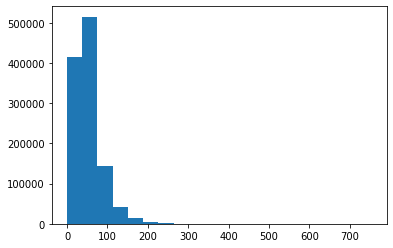

In [17]:
import numpy as np
import matplotlib.pyplot as plt

t = np.array([len(t) for t in desc])
plt.hist(t, bins=20)
plt.show()

In [ ]:
# preprocess mention dataset
import json
import numpy as np

from tqdm import tqdm_notebook as tqdm
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')

index = [0]

with open('/data1/ujiie/wiki_resource/training_data.jsonl', 'r') as f:
    with open('/data1/ujiie/wiki_resource/training_data_preprocessd_for_bert-base-japanese.jsonl', 'w') as fout:
        bar = tqdm(total=21959869)
        for line in f:
            line = line.rstrip()
            if not line:
                continue
            line = json.loads(line)

            line['left_ctxt_tokens'] = tokenizer.tokenize(line['left_context'])
            line['right_ctxt_tokens'] = tokenizer.tokenize(line['right_context'])
            line['mention_tokens'] = tokenizer.tokenize(line['mention'])
            output = json.dumps(line) + '\n'
            index.append(index[-1] + len(output))
            #index = np.append(index, index[-1] + len(output))
            fout.write(output)
            bar.update(1)
index = np.array(index)        
np.save('/data1/ujiie/wiki_resource/training_data_preprocessd_for_bert-base-japanese_index.npy', index)